In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt
import healpy as hp
import pandas as pd
import sqlite3
import rubin_sim
import rubin_sim.maf as maf
from rubin_sim.scheduler.utils import SkyAreaGenerator
from rubin_sim.data import get_baseline
rubin_sim.__version__
import meanz_modules as mzmod
import scipy
import sklearn

In [18]:
from os import path
opsim_fname = rubin_sim.data.get_baseline()
run_name = path.splitext(path.basename(opsim_fname))[0]
nside=64

In [5]:
import importlib
importlib.reload(mzmod)

<module 'meanz_modules' from '/pscratch/sd/r/rmandelb/ObsStrat/code/meanz_uniformity/meanz_modules.py'>

# Unsupervised clustering routines

Boris pointed out that the structure in the depth maps due to rolling should be easy for an unsupervised clustering algorithm to identify, and that could be another pathway to an "area at risk" metric.  The nice thing about this is that it could potentially address the disadvantage of the previous approach we considered, by allowing us to identify the areas to include/exclude based on inspection of a strategy on its own.

Below are a number of utility routines that take maps of total exposure time, construct a suitable dataset for clustering (we have to rescale RA/dec to avoid their variation dominating over the depth variations, and apply masks), run an unsupervised clustering algorithm, and then inspect the results at the map level.

In [6]:
def make_clustering_dataset(depth_map, maskval=0, priority_fac=0.9, nside=64):
    # A utility routine to get a dataset for unsupervised clustering.  Note:
    # - We want the unmasked regions of the depth map only.
    # - We assume masked regions are set to `maskval`, and cut 0.1 magnitudes above that.
    # - We really want it to look at depth fluctuations.  So, we have to rescale the 
    #   RA/dec dimensions to avoid them being prioritized because their values are larger and
    #   have more variation than depth.  Currently we rescale RA/dec such that their 
    #   standard deviations are 1-priority_fac times the standard deviation of the depth map.
    #   That's why priority_fac is a tunable parameter; it should be between 0 and 1
    if priority_fac<0 or priority_fac>=1:
        raise ValueError("priority_fac must lie between 0 and 1")
    theta, phi = hp.pixelfunc.pix2ang(nside, ipix=np.arange(hp.nside2npix(nside)))
    # theta is 0 at the north pole, pi/2 at equator, pi at south pole; phi maps to RA
    ra = np.rad2deg(phi)
    dec = np.rad2deg(0.5 * np.pi - theta)
    
    # Make a 3D numpy array containing the unmasked regions, including a rescaling factor to prioritize the depth
    n_unmasked = len(depth_map[depth_map>0.1])
    my_data = np.zeros((n_unmasked, 3))
    cutval = 0.1 + maskval
    my_data[:,0] = ra[depth_map>cutval]*(1-priority_fac)*np.std(depth_map[depth_map>cutval])/np.std(ra[depth_map>cutval])
    my_data[:,1] = dec[depth_map>cutval]*(1-priority_fac)*np.std(depth_map[depth_map>cutval])/np.std(dec[depth_map>cutval])
    my_data[:,2] = depth_map[depth_map>cutval]
    return my_data

In [7]:
def apply_clustering(clustering_data):
    # A thin wrapper around sklearn routines (can swap out which one we are using systematically).
    # We fix parameters like `n_clusters` since realistically we know for rolling that we should expect 2 clusters.
    #from sklearn.cluster import SpectralClustering
    #clustering = SpectralClustering(n_clusters=2, assign_labels='discretize', random_state=0).fit(clustering_data)
    from sklearn.cluster import KMeans
    clustering = KMeans(n_clusters=2, random_state=0, n_init="auto").fit(clustering_data)
    labels = clustering.labels_ + 1
    return labels

In [8]:
def expand_labels(depth_map, labels, maskval=0):
    # A utility to apply the labels from a masked version of a depth map back to the entire depth map.
    expanded_labels = np.zeros(hp.nside2npix(nside))
    cutval = maskval+0.1
    expanded_labels[depth_map>cutval] = labels
    return expanded_labels

In [9]:
def get_area_stats(depth_map, labels, maskval=0, n_clusters=2):
    # A routine to get some statistics of the clustering: area fractions, median map values
    expanded_labels = expand_labels(depth_map, labels, maskval=maskval)
    cutval = maskval+0.1
    area_frac = []
    med_val = []
    for i in range(n_clusters):
        new_map = depth_map.copy()
        new_map[expanded_labels!=i+1] = maskval
        this_area_frac = len(new_map[new_map>cutval])/len(depth_map[depth_map>cutval])
        this_med_val = np.median(new_map[new_map>cutval])
        area_frac.append(this_area_frac)
        med_val.append(this_med_val)
    return area_frac, med_val

In [10]:
def show_clusters(depth_map, labels, maskval=0, n_clusters=2, min=500, max=3000):
    # A routine to show the clusters found by the unsupervised clustering algorithm (start with original map then 2 clusters).
    expanded_labels = expand_labels(depth_map, labels, maskval=maskval)
    hp.visufunc.mollview(depth_map, min=min, max=max)
    for i in range(n_clusters):
        new_map = depth_map.copy()
        new_map[expanded_labels!=i+1] = maskval
        hp.visufunc.mollview(new_map, min=min, max=max)

    return get_area_stats(depth_map, labels, maskval=maskval, n_clusters=n_clusters)

# Towards a FoM-based metric with an acceptably homogeneous survey footprint

In [11]:
# Let's make code that pulls out the northern/southern galactic regions more robustly, and gets statistics of the footprint by region.
from astropy import units as u
from astropy.coordinates import SkyCoord
def _is_ngp(ra, dec):
    c = SkyCoord(ra=ra*u.degree, dec=dec*u.degree, frame='icrs')
    lat = c.galactic.b.deg
    return lat >= 0

def get_stats_by_region(use_map, nside, maskval=0, region='all'):
    if region not in ['all','north','south']:
        raise ValueError('Invalid region %s'%region)
    to_use = (use_map > maskval)
    
    if region != 'all':
        # Find the north/south part of the map as requested
        npix = hp.nside2npix(nside)
        ra, dec = hp.pix2ang(hp.npix2nside(npix), range(npix), lonlat=True)
        ngp_mask = _is_ngp(ra, dec)
        if region=='north':
            reg_mask = ngp_mask
        else: 
            reg_mask = ~ngp_mask
        to_use = to_use & reg_mask
    
    # Calculate the desired stats
    reg_mad = scipy.stats.median_abs_deviation(use_map[to_use])
    reg_median = np.median(use_map[to_use])
    reg_std = np.std(use_map[to_use])
    
    # Return the values
    return(reg_mad, reg_median, reg_std)


In [21]:
def has_stripes(map, nside, threshold=0.1):
    """
    A utility to find whether a particular routine has stripey features in the exposure time map.
    """
    # Analyze the exposure time map to get MAD, median, std in north/south.
    mad = {}
    med = {}
    frac_scatter = {}
    regions = ['north', 'south']
    for region in regions:
        mad[region], med[region], _ = get_stats_by_region(map, nside, region=region)
        frac_scatter[region] = mad[region]/med[region]
    test_statistic = np.abs(frac_scatter['north']/frac_scatter['south']-1)
    if test_statistic < threshold:
        return False
    else:
        return True

# FoM metric tests

In [22]:
def show_fom(bd):
    print(bd[list(bd.keys())[0]].summary_values['3x2ptFoM'])
    
def return_fom(bd):
    return bd[list(bd.keys())[0]].summary_values['3x2ptFoM']

What's above is very promising, so let's string it together into a metric that we'll call UniformAreaFoMFraction:

1. Obtain the exposure time map for the given strategy and year.
2. Check for stripes in the exposure time map.
3. If no, return 1 (i.e. we don't need to remove area and lose constraining power)
4. If yes, do the clustering and return the FoM from one of the regions divided by the original FoM before these cuts.

This metric is defined so that "1" means no cuts and less than one means we've cut the area.  It's defined with reference to itself rather than with reference to e.g. some idealized no-roll case, but we could reconsider this.

We'll have a keyword argument that controls the verbosity, so we can get intermediate diagnostic outputs.

For now this is simply written as a python function, but it should be mappable onto a summary metric in MAF.

In [23]:
# Utility routines to check for bimodality of depth maps
def double_gauss(x, *args):
    # Convenience function for fitting to a sum of Gaussians.
    m1, m2, s1, s2, k1, k2 = args
    ret = k1*scipy.stats.norm.pdf(x, loc=m1 ,scale=s1)
    ret += k2*scipy.stats.norm.pdf(x, loc=m2 ,scale=s2)
    return ret

def single_gauss(x, *args):
    # Convenience function for fitting to a sum of Gaussians.
    m1, s1, k1 = args
    ret = k1*scipy.stats.norm.pdf(x, loc=m1 ,scale=s1)
    return ret

def fit_exptime_dist(map, maskval=0):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cutval = maskval + 0.1
    mapvals_use = map[map>cutval]
    params_single = [np.median(mapvals_use), np.std(mapvals_use), 1]
    params_double = [np.median(mapvals_use)-2*np.std(mapvals_use), np.median(mapvals_use)+2*np.std(mapvals_use),
                     np.std(mapvals_use), np.std(mapvals_use), 0.5, 0.5]
    counts, bins, _ = plt.hist(map[map>0], density=True, bins=40, label='histogram')
    bin_mids = 0.5*(bins[1:] + bins[:-1])
    plt.xlabel('RIZ exposure time')

    # Fitting
    fitted_params_double, cov_double = scipy.optimize.curve_fit(double_gauss, bin_mids, counts, p0=params_double)
    fitted_params_single, cov_single = scipy.optimize.curve_fit(single_gauss, bin_mids, counts, p0=params_single)
    plt.plot(bin_mids, double_gauss(bin_mids, *fitted_params_double), label='double Gaussian fit')
    plt.plot(bin_mids, single_gauss(bin_mids, *fitted_params_single), label='single Gaussian fit')
    chi2_double = np.sum((counts-double_gauss(bin_mids, *fitted_params_double))**2)
    chi2_single = np.sum((counts-single_gauss(bin_mids, *fitted_params_single))**2)
    #print('Double Gaussian params, chi2:', *fitted_params_double, chi2_double)
    #print('Single Gaussian params, chi2:', *fitted_params_single, chi2_single)
    #print('chi2 ratio:', chi2_double/chi2_single)
    if fitted_params_double[5] < fitted_params_double[4]:
        dratio = fitted_params_double[5]/fitted_params_double[4]
    else:
        dratio = fitted_params_double[4]/fitted_params_double[5]
    #print('Double Gaussian ratio:', dratio)
    plt.legend()
    return chi2_double/chi2_single, dratio

def bimodality_test(map, verbose=False, chi2_ratio_thres = 0.9, dratio_thres=0.08):
    chi2_ratio, dratio = fit_exptime_dist(map)
    if verbose: print("Verbose bimodality test: %f %f %f %f"%(chi2_ratio, chi2_ratio_thres, dratio, dratio_thres))
    if chi2_ratio < chi2_ratio_thres and dratio > dratio_thres:
        return True
    else:
        return False

In [39]:
def UniformAreaFoMFraction(use_run_name, use_opsim_fname, year=10, nside=64, verbose=True):
    """Docstrings go here :)"""
    # Get the exposure time map for the given strategy, year.
    # When integrating into MAF will have to not use our custom routine; code will become simpler (need to test that here).
    if verbose: print("Getting exposure time map for this strategy, year, and nside:", use_run_name,
                     year, nside)
    _, _, map = mzmod.metric_plots(use_run_name, use_opsim_fname, use_metric=maf.RIZDetectionCoaddExposureTime(), year=year, nside=nside, return_map=True)

    if verbose:
        # Define a set of histogram bins
        print("Verbose mode - histogram of exposure times for unmasked region")
        min_t, max_t = np.percentile(map[map>0], (1,99))
        n_bins = 25
        bins = np.linspace(min_t, max_t, int(n_bins+1))
        plt.hist(map[map>0], bins=bins, density=True, histtype='step')
        plt.xlabel('RIZ cumulative exposure time')

    # Check for stripiness
    stripes = has_stripes(map, nside)
    if verbose: print("Verbose mode - stripe test returned", stripes)

    if not stripes:
        return 1
    else:
        # Do the clustering if we got to this point
        if verbose: print("Verbose mode - Carrying out the clustering exercise for this map")
        clustering_data = make_clustering_dataset(map)
        labels = apply_clustering(clustering_data)
        area_frac, med_val = get_area_stats(map, labels)
        if verbose:
            print("Verbose mode - showing original map and clusters identified for this map")
            show_clusters(map, labels)
            print("Area fractions", area_frac)
            print("Median exposure time values", med_val)
            print("Median exposure time ratio", np.max(med_val)/np.min(med_val))
            print("Verbose mode - proceeding with area cuts")

        # Get the FoM without/with cuts.  We want to check the FoM for each area, if we're doing cuts, and 
        # return the higher one. This will typically be for the larger area, but not necessarily, if the smaller area
        # is deeper.
        expanded_labels = expand_labels(map, labels)
        my_hpid_1 = np.where(labels == 1)[0]
        my_hpid_2 = np.where(labels == 2)[0]
        bgroup1, bd1 = mzmod.get_3x2pt_metric(use_run_name, use_opsim_fname, year=year, my_hpid=my_hpid_1)
        fom1 = return_fom(bd1)
        bgroup2, bd2 = mzmod.get_3x2pt_metric(use_run_name, use_opsim_fname, year=year, my_hpid=my_hpid_2)
        fom2 = return_fom(bd2)
        fom = np.max((fom1, fom2))
        if verbose:
            print("Verbose mode - select which area to report the FoM for", fom1, fom2, fom)
        bgroup, bd = mzmod.get_3x2pt_metric(use_run_name, use_opsim_fname, year=year, my_hpid=None)
        fom_total = return_fom(bd)
        if verbose:
            print("Verbose mode - original (uncut) FoM", fom_total)
            print("Verbose mode - FoM ratio", fom/fom_total)
        return fom/fom_total


In [40]:
sim_list = ['/pscratch/sd/r/rhlozek/rubin_sim_data/sim_baseline/baseline_v3.3_10yrs.db',
               '/pscratch/sd/r/rhlozek/rubin_sim_data/noroll/noroll_v3.3_10yrs.db',
               '/pscratch/sd/b/beckermr/v3.4_sims_rubin/roll_uniform_mjdp0_v3.4_10yrs.db',
               '/pscratch/sd/b/beckermr/v3.4_sims_rubin/baseline_v3.4_10yrs.db']
name_list = [path.splitext(path.basename(sim))[0] for sim in sim_list]

Getting exposure time map for this strategy, year, and nside: baseline_v3.3_10yrs 1 64
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes


/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/rubin_sim/maf/maps/dust_map.py:44: UserWarning: Slicer value of nside 64 different from map value 128, using slicer value
  warnings.warn(


Verbose mode - histogram of exposure times for unmasked region
Verbose mode - stripe test returned False


1

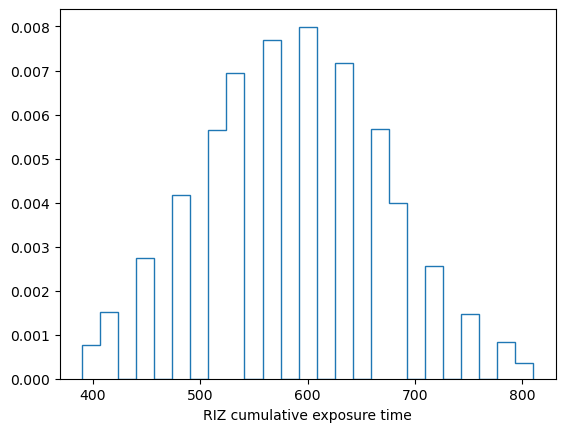

In [41]:
UniformAreaFoMFraction(name_list[0], sim_list[0], year=1, verbose=True)

In [48]:
# Do this for all strategies in each year.
year_list = np.arange(1,11)
frac_list = {}
for i in range(len(sim_list)):
    frac_list[name_list[i]] = np.zeros_like(year_list).astype(float)
    for year_ind in range(len(year_list)):
        frac_list[name_list[i]][year_ind] = UniformAreaFoMFraction(name_list[i], sim_list[i],
                                                                   year=year_list[year_ind], verbose=False)

Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes


/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/rubin_sim/maf/maps/dust_map.py:44: UserWarning: Slicer value of nside 64 different from map value 128, using slicer value
  warnings.warn(


Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes


/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/rubin_sim/maf/maps/dust_map.py:44: UserWarning: Slicer value of nside 64 different from map value 128, using slicer value
  warnings.warn(


Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes


/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/rubin_sim/maf/maps/dust_map.py:44: UserWarning: Slicer value of nside 64 different from map value 128, using slicer value
  warnings.warn(
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes


/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/rubin_sim/maf/maps/dust_map.py:44: UserWarning: Slicer value of nside 64 different from map value 128, using slicer value
  warnings.warn(
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes


/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/rubin_sim/maf/maps/dust_map.py:44: UserWarning: Slicer value of nside 64 different from map value 128, using slicer value
  warnings.warn(
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes


/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/rubin_sim/maf/maps/dust_map.py:44: UserWarning: Slicer value of nside 64 different from map value 128, using slicer value
  warnings.warn(


Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes


/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/rubin_sim/maf/maps/dust_map.py:44: UserWarning: Slicer value of nside 64 different from map value 128, using slicer value
  warnings.warn(
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes


/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/rubin_sim/maf/maps/dust_map.py:44: UserWarning: Slicer value of nside 64 different from map value 128, using slicer value
  warnings.warn(
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes


/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/rubin_sim/maf/maps/dust_map.py:44: UserWarning: Slicer value of nside 64 different from map value 128, using slicer value
  warnings.warn(
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes


/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/rubin_sim/maf/maps/dust_map.py:44: UserWarning: Slicer value of nside 64 different from map value 128, using slicer value
  warnings.warn(


Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes


/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/rubin_sim/maf/maps/dust_map.py:44: UserWarning: Slicer value of nside 64 different from map value 128, using slicer value
  warnings.warn(
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes


/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/rubin_sim/maf/maps/dust_map.py:44: UserWarning: Slicer value of nside 64 different from map value 128, using slicer value
  warnings.warn(
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes


/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/rubin_sim/maf/maps/dust_map.py:44: UserWarning: Slicer value of nside 64 different from map value 128, using slicer value
  warnings.warn(
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes


/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/rubin_sim/maf/maps/dust_map.py:44: UserWarning: Slicer value of nside 64 different from map value 128, using slicer value
  warnings.warn(


Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes


/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/rubin_sim/maf/maps/dust_map.py:44: UserWarning: Slicer value of nside 64 different from map value 128, using slicer value
  warnings.warn(
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes


/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/rubin_sim/maf/maps/dust_map.py:44: UserWarning: Slicer value of nside 64 different from map value 128, using slicer value
  warnings.warn(
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes


/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/rubin_sim/maf/maps/dust_map.py:44: UserWarning: Slicer value of nside 64 different from map value 128, using slicer value
  warnings.warn(
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes


/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/rubin_sim/maf/maps/dust_map.py:44: UserWarning: Slicer value of nside 64 different from map value 128, using slicer value
  warnings.warn(


Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes


/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/rubin_sim/maf/maps/dust_map.py:44: UserWarning: Slicer value of nside 64 different from map value 128, using slicer value
  warnings.warn(
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes


/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/rubin_sim/maf/maps/dust_map.py:44: UserWarning: Slicer value of nside 64 different from map value 128, using slicer value
  warnings.warn(
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes


/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/rubin_sim/maf/maps/dust_map.py:44: UserWarning: Slicer value of nside 64 different from map value 128, using slicer value
  warnings.warn(
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes


/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/rubin_sim/maf/maps/dust_map.py:44: UserWarning: Slicer value of nside 64 different from map value 128, using slicer value
  warnings.warn(


Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes


/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/rubin_sim/maf/maps/dust_map.py:44: UserWarning: Slicer value of nside 64 different from map value 128, using slicer value
  warnings.warn(
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes


/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/rubin_sim/maf/maps/dust_map.py:44: UserWarning: Slicer value of nside 64 different from map value 128, using slicer value
  warnings.warn(
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes


/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/rubin_sim/maf/maps/dust_map.py:44: UserWarning: Slicer value of nside 64 different from map value 128, using slicer value
  warnings.warn(
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes


/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/rubin_sim/maf/maps/dust_map.py:44: UserWarning: Slicer value of nside 64 different from map value 128, using slicer value
  warnings.warn(


Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes


/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/rubin_sim/maf/maps/dust_map.py:44: UserWarning: Slicer value of nside 64 different from map value 128, using slicer value
  warnings.warn(
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes


/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/rubin_sim/maf/maps/dust_map.py:44: UserWarning: Slicer value of nside 64 different from map value 128, using slicer value
  warnings.warn(
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes


/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/rubin_sim/maf/maps/dust_map.py:44: UserWarning: Slicer value of nside 64 different from map value 128, using slicer value
  warnings.warn(
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes


/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/rubin_sim/maf/maps/dust_map.py:44: UserWarning: Slicer value of nside 64 different from map value 128, using slicer value
  warnings.warn(


Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes


/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/rubin_sim/maf/maps/dust_map.py:44: UserWarning: Slicer value of nside 64 different from map value 128, using slicer value
  warnings.warn(
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes


/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/rubin_sim/maf/maps/dust_map.py:44: UserWarning: Slicer value of nside 64 different from map value 128, using slicer value
  warnings.warn(
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes


/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/rubin_sim/maf/maps/dust_map.py:44: UserWarning: Slicer value of nside 64 different from map value 128, using slicer value
  warnings.warn(
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes


/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/rubin_sim/maf/maps/dust_map.py:44: UserWarning: Slicer value of nside 64 different from map value 128, using slicer value
  warnings.warn(


Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes


/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/rubin_sim/maf/maps/dust_map.py:44: UserWarning: Slicer value of nside 64 different from map value 128, using slicer value
  warnings.warn(


Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes


/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/rubin_sim/maf/maps/dust_map.py:44: UserWarning: Slicer value of nside 64 different from map value 128, using slicer value
  warnings.warn(


Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes


/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/rubin_sim/maf/maps/dust_map.py:44: UserWarning: Slicer value of nside 64 different from map value 128, using slicer value
  warnings.warn(


Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes


/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/rubin_sim/maf/maps/dust_map.py:44: UserWarning: Slicer value of nside 64 different from map value 128, using slicer value
  warnings.warn(


Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes


/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/rubin_sim/maf/maps/dust_map.py:44: UserWarning: Slicer value of nside 64 different from map value 128, using slicer value
  warnings.warn(


Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes


/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/rubin_sim/maf/maps/dust_map.py:44: UserWarning: Slicer value of nside 64 different from map value 128, using slicer value
  warnings.warn(


Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes


/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/rubin_sim/maf/maps/dust_map.py:44: UserWarning: Slicer value of nside 64 different from map value 128, using slicer value
  warnings.warn(


Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes


/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/rubin_sim/maf/maps/dust_map.py:44: UserWarning: Slicer value of nside 64 different from map value 128, using slicer value
  warnings.warn(


Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes


/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/rubin_sim/maf/maps/dust_map.py:44: UserWarning: Slicer value of nside 64 different from map value 128, using slicer value
  warnings.warn(


Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes


/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/rubin_sim/maf/maps/dust_map.py:44: UserWarning: Slicer value of nside 64 different from map value 128, using slicer value
  warnings.warn(


Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes


/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/rubin_sim/maf/maps/dust_map.py:44: UserWarning: Slicer value of nside 64 different from map value 128, using slicer value
  warnings.warn(


Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes


/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/rubin_sim/maf/maps/dust_map.py:44: UserWarning: Slicer value of nside 64 different from map value 128, using slicer value
  warnings.warn(


Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes


/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/rubin_sim/maf/maps/dust_map.py:44: UserWarning: Slicer value of nside 64 different from map value 128, using slicer value
  warnings.warn(
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes


/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/rubin_sim/maf/maps/dust_map.py:44: UserWarning: Slicer value of nside 64 different from map value 128, using slicer value
  warnings.warn(
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes


/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/rubin_sim/maf/maps/dust_map.py:44: UserWarning: Slicer value of nside 64 different from map value 128, using slicer value
  warnings.warn(
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes


/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/rubin_sim/maf/maps/dust_map.py:44: UserWarning: Slicer value of nside 64 different from map value 128, using slicer value
  warnings.warn(


Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes


/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/rubin_sim/maf/maps/dust_map.py:44: UserWarning: Slicer value of nside 64 different from map value 128, using slicer value
  warnings.warn(
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes


/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/rubin_sim/maf/maps/dust_map.py:44: UserWarning: Slicer value of nside 64 different from map value 128, using slicer value
  warnings.warn(
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes


/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/rubin_sim/maf/maps/dust_map.py:44: UserWarning: Slicer value of nside 64 different from map value 128, using slicer value
  warnings.warn(
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes


/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/rubin_sim/maf/maps/dust_map.py:44: UserWarning: Slicer value of nside 64 different from map value 128, using slicer value
  warnings.warn(


Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes


/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/rubin_sim/maf/maps/dust_map.py:44: UserWarning: Slicer value of nside 64 different from map value 128, using slicer value
  warnings.warn(


Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes


/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/rubin_sim/maf/maps/dust_map.py:44: UserWarning: Slicer value of nside 64 different from map value 128, using slicer value
  warnings.warn(
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes


/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/rubin_sim/maf/maps/dust_map.py:44: UserWarning: Slicer value of nside 64 different from map value 128, using slicer value
  warnings.warn(
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes


/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/rubin_sim/maf/maps/dust_map.py:44: UserWarning: Slicer value of nside 64 different from map value 128, using slicer value
  warnings.warn(
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes


/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/rubin_sim/maf/maps/dust_map.py:44: UserWarning: Slicer value of nside 64 different from map value 128, using slicer value
  warnings.warn(


Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes


/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/rubin_sim/maf/maps/dust_map.py:44: UserWarning: Slicer value of nside 64 different from map value 128, using slicer value
  warnings.warn(
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes


/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/rubin_sim/maf/maps/dust_map.py:44: UserWarning: Slicer value of nside 64 different from map value 128, using slicer value
  warnings.warn(
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes


/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/rubin_sim/maf/maps/dust_map.py:44: UserWarning: Slicer value of nside 64 different from map value 128, using slicer value
  warnings.warn(
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes


/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/rubin_sim/maf/maps/dust_map.py:44: UserWarning: Slicer value of nside 64 different from map value 128, using slicer value
  warnings.warn(


Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes


/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/rubin_sim/maf/maps/dust_map.py:44: UserWarning: Slicer value of nside 64 different from map value 128, using slicer value
  warnings.warn(


Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes


/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/rubin_sim/maf/maps/dust_map.py:44: UserWarning: Slicer value of nside 64 different from map value 128, using slicer value
  warnings.warn(
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes


/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/rubin_sim/maf/maps/dust_map.py:44: UserWarning: Slicer value of nside 64 different from map value 128, using slicer value
  warnings.warn(
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes


/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/rubin_sim/maf/maps/dust_map.py:44: UserWarning: Slicer value of nside 64 different from map value 128, using slicer value
  warnings.warn(
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes


/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/rubin_sim/maf/maps/dust_map.py:44: UserWarning: Slicer value of nside 64 different from map value 128, using slicer value
  warnings.warn(


Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes


/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/rubin_sim/maf/maps/dust_map.py:44: UserWarning: Slicer value of nside 64 different from map value 128, using slicer value
  warnings.warn(


Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes


/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/rubin_sim/maf/maps/dust_map.py:44: UserWarning: Slicer value of nside 64 different from map value 128, using slicer value
  warnings.warn(


Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes


/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/rubin_sim/maf/maps/dust_map.py:44: UserWarning: Slicer value of nside 64 different from map value 128, using slicer value
  warnings.warn(


Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes


/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/rubin_sim/maf/maps/dust_map.py:44: UserWarning: Slicer value of nside 64 different from map value 128, using slicer value
  warnings.warn(
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes


/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/rubin_sim/maf/maps/dust_map.py:44: UserWarning: Slicer value of nside 64 different from map value 128, using slicer value
  warnings.warn(
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes


/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/rubin_sim/maf/maps/dust_map.py:44: UserWarning: Slicer value of nside 64 different from map value 128, using slicer value
  warnings.warn(
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes


/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/rubin_sim/maf/maps/dust_map.py:44: UserWarning: Slicer value of nside 64 different from map value 128, using slicer value
  warnings.warn(


Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes


/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/rubin_sim/maf/maps/dust_map.py:44: UserWarning: Slicer value of nside 64 different from map value 128, using slicer value
  warnings.warn(
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes


/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/rubin_sim/maf/maps/dust_map.py:44: UserWarning: Slicer value of nside 64 different from map value 128, using slicer value
  warnings.warn(
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes


/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/rubin_sim/maf/maps/dust_map.py:44: UserWarning: Slicer value of nside 64 different from map value 128, using slicer value
  warnings.warn(
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes


/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/rubin_sim/maf/maps/dust_map.py:44: UserWarning: Slicer value of nside 64 different from map value 128, using slicer value
  warnings.warn(


Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes


/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/rubin_sim/maf/maps/dust_map.py:44: UserWarning: Slicer value of nside 64 different from map value 128, using slicer value
  warnings.warn(
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes


/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/rubin_sim/maf/maps/dust_map.py:44: UserWarning: Slicer value of nside 64 different from map value 128, using slicer value
  warnings.warn(
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes


/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/rubin_sim/maf/maps/dust_map.py:44: UserWarning: Slicer value of nside 64 different from map value 128, using slicer value
  warnings.warn(
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes


/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/rubin_sim/maf/maps/dust_map.py:44: UserWarning: Slicer value of nside 64 different from map value 128, using slicer value
  warnings.warn(


Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes


/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/rubin_sim/maf/maps/dust_map.py:44: UserWarning: Slicer value of nside 64 different from map value 128, using slicer value
  warnings.warn(
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes


/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/rubin_sim/maf/maps/dust_map.py:44: UserWarning: Slicer value of nside 64 different from map value 128, using slicer value
  warnings.warn(
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes


/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/rubin_sim/maf/maps/dust_map.py:44: UserWarning: Slicer value of nside 64 different from map value 128, using slicer value
  warnings.warn(
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes


/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/rubin_sim/maf/maps/dust_map.py:44: UserWarning: Slicer value of nside 64 different from map value 128, using slicer value
  warnings.warn(


Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes


/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/rubin_sim/maf/maps/dust_map.py:44: UserWarning: Slicer value of nside 64 different from map value 128, using slicer value
  warnings.warn(
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes


/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/rubin_sim/maf/maps/dust_map.py:44: UserWarning: Slicer value of nside 64 different from map value 128, using slicer value
  warnings.warn(
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes


/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/rubin_sim/maf/maps/dust_map.py:44: UserWarning: Slicer value of nside 64 different from map value 128, using slicer value
  warnings.warn(
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes


/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/rubin_sim/maf/maps/dust_map.py:44: UserWarning: Slicer value of nside 64 different from map value 128, using slicer value
  warnings.warn(


Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes


/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/rubin_sim/maf/maps/dust_map.py:44: UserWarning: Slicer value of nside 64 different from map value 128, using slicer value
  warnings.warn(
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes


/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/rubin_sim/maf/maps/dust_map.py:44: UserWarning: Slicer value of nside 64 different from map value 128, using slicer value
  warnings.warn(
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes


/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/rubin_sim/maf/maps/dust_map.py:44: UserWarning: Slicer value of nside 64 different from map value 128, using slicer value
  warnings.warn(
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes


/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/rubin_sim/maf/maps/dust_map.py:44: UserWarning: Slicer value of nside 64 different from map value 128, using slicer value
  warnings.warn(


Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes


/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/rubin_sim/maf/maps/dust_map.py:44: UserWarning: Slicer value of nside 64 different from map value 128, using slicer value
  warnings.warn(
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes


/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/rubin_sim/maf/maps/dust_map.py:44: UserWarning: Slicer value of nside 64 different from map value 128, using slicer value
  warnings.warn(
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes


/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/rubin_sim/maf/maps/dust_map.py:44: UserWarning: Slicer value of nside 64 different from map value 128, using slicer value
  warnings.warn(
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes


/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/rubin_sim/maf/maps/dust_map.py:44: UserWarning: Slicer value of nside 64 different from map value 128, using slicer value
  warnings.warn(


Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes


/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/rubin_sim/maf/maps/dust_map.py:44: UserWarning: Slicer value of nside 64 different from map value 128, using slicer value
  warnings.warn(
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes


/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/rubin_sim/maf/maps/dust_map.py:44: UserWarning: Slicer value of nside 64 different from map value 128, using slicer value
  warnings.warn(
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes


/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/rubin_sim/maf/maps/dust_map.py:44: UserWarning: Slicer value of nside 64 different from map value 128, using slicer value
  warnings.warn(
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes


/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/rubin_sim/maf/maps/dust_map.py:44: UserWarning: Slicer value of nside 64 different from map value 128, using slicer value
  warnings.warn(


[1.         0.68653748 0.65872172 0.64005084 0.63439428 0.62628693
 0.62365835 0.61816383 0.61781803 1.        ]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
[1.         0.69420116 0.65991819 1.         0.62930723 0.62297082
 1.         0.61961612 1.         1.        ]
[1.         0.68348512 0.65635301 0.63843717 0.63259378 0.62530536
 0.62238027 0.6170928  0.61661065 1.        ]


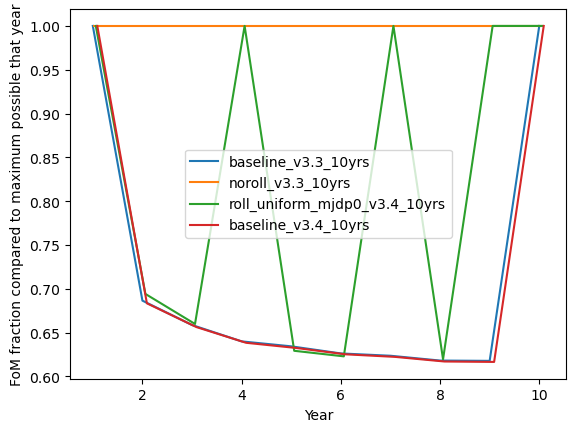

In [50]:
offset=0
for key in frac_list.keys():
    print(frac_list[key])
    plt.plot(year_list+offset*0.03, frac_list[key], label=key)
    offset+=1
plt.xlabel('Year')
plt.ylabel('FoM fraction compared to maximum possible that year')
plt.legend()